In [6]:
#0. CASO 5: CARGAR LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
import shap

In [7]:
#1. CARGAR DE DATOS
df = pd.read_csv("taller2_MLE.csv")

In [8]:
df.head()

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0


In [9]:
df.describe()

,edad,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,cerrara_cuenta
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,46.141000,20416.034312,2.987800,6.047000,0.699000,0.612400,0.489000,3.018240,34.986158,0.140400
std,16.357733,13588.538852,1.420583,2.484195,0.458739,0.487251,0.700555,1.145849,8.156743,0.347436
min,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000,0.000000
25%,32.000000,9780.610000,2.000000,4.000000,0.000000,0.000000,0.000000,2.000000,29.570000,0.000000
50%,46.000000,19784.830000,3.000000,6.000000,1.000000,1.000000,0.000000,3.000000,35.120000,0.000000
75%,60.000000,29887.305000,4.000000,8.000000,1.000000,1.000000,1.000000,4.000000,40.490000,0.000000
max,74.000000,66416.670000,5.000000,17.000000,1.000000,1.000000,6.000000,5.000000,65.040000,1.000000


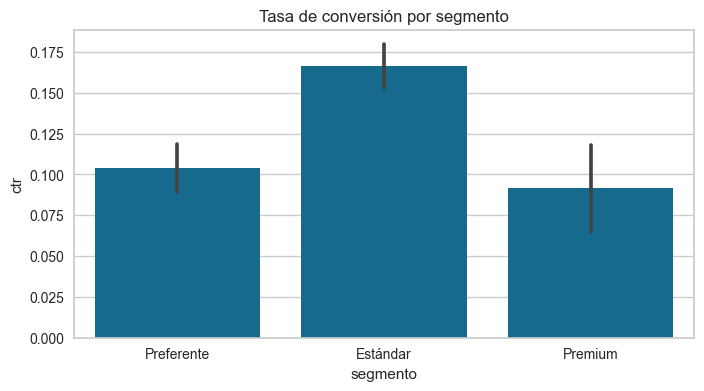

In [11]:
#2.ANALISIS EXPLORATORIO; CTR por plataforma
df['ctr']=df['cerrara_cuenta']
plt.figure(figsize=(8,4))
sns.barplot(data=df,x='segmento',y='ctr')
plt.title("Tasa de conversión por segmento")
plt.show()

In [13]:
#3.FEATURE ENGINEERING: ENGAGEMENT COMBINADO
df['engagement'] = np.sqrt(df['numero_productos']*0.7+df['visitas_app_mes']*1.5)

In [14]:
# Categorizar edad
df['edad_categoria'] = pd.cut(
    df['edad'],
    bins=[0, 30, 60, 120],
    labels=['Corto', 'Medio', 'Largo']
)

In [15]:
# Crear variable combinada de region y rango_ingresos
df['region_rango_ingresos'] = df['region'] + "_" + df['rango_ingresos']

In [27]:
get_config('X').dtypes


segmento                 category
saldo_total               float32
numero_productos             int8
visitas_app_mes              int8
usa_web                      int8
usa_tarjeta_credito          int8
reclamos_6m                  int8
satisfaccion_encuesta     float32
tasa_credito_personal     float32
rango_ingresos           category
region                   category
engagement                float32
edad_categoria           category
region_rango_ingresos    category
dtype: object

In [28]:
clf = setup(
    data=df,
    target='cerrara_cuenta',
    session_id=2025,
    ignore_features=['ctr', 'edad'],
    normalize=True,
    feature_selection=False,
    remove_multicollinearity=False,
    transformation=True,
    transformation_method='yeo-johnson',
    verbose=False
)


In [29]:
# Comparar modelos automáticamente
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8597,0.6258,0.0000,0.0000,0.0000,0.0000,0.0000,1.3690
ridge,Ridge Classifier,0.8597,0.6252,0.0000,0.0000,0.0000,0.0000,0.0000,0.1530
lda,Linear Discriminant Analysis,0.8597,0.6248,0.0000,0.0000,0.0000,0.0000,0.0000,0.0950
dummy,Dummy Classifier,0.8597,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0970
rf,Random Forest Classifier,0.8591,0.6122,0.0040,0.1500,0.0078,0.0045,0.0145,0.2730
ada,Ada Boost Classifier,0.8583,0.6186,0.0061,0.1000,0.0115,0.0056,0.0097,0.1650
svm,SVM - Linear Kernel,0.8577,0.5445,0.0000,0.0000,0.0000,-0.0039,-0.0099,0.1560
gbc,Gradient Boosting Classifier,0.8571,0.6166,0.0143,0.3250,0.0272,0.0149,0.0400,0.3120
et,Extra Trees Classifier,0.8537,0.5985,0.0122,0.1929,0.0221,0.0050,0.0104,0.2450
lightgbm,Light Gradient Boosting Machine,0.8483,0.5867,0.0183,0.1483,0.0322,0.0031,0.0046,0.2230


In [33]:
gbc_model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8629,0.6036,0.0204,1.0000,0.0400,0.0346,0.1327
1,0.8600,0.6927,0.0204,0.5000,0.0392,0.0285,0.0787
2,0.8571,0.6124,0.0000,0.0000,0.0000,-0.0056,-0.0216
3,0.8543,0.5720,0.0000,0.0000,0.0000,-0.0111,-0.0306
4,0.8600,0.6114,0.0204,0.5000,0.0392,0.0285,0.0787
5,0.8486,0.5915,0.0000,0.0000,0.0000,-0.0216,-0.0434
6,0.8629,0.6375,0.0408,0.6667,0.0769,0.0618,0.1411
7,0.8571,0.5862,0.0204,0.3333,0.0385,0.0227,0.0518
8,0.8543,0.6392,0.0204,0.2500,0.0377,0.0170,0.0341


In [34]:
# 🔍 Interpretar con SHAP manualmente
X_train_transformed = get_config('X_train_transformed')
explainer = shap.TreeExplainer(gbc_model)
shap_values = explainer.shap_values(X_train_transformed)

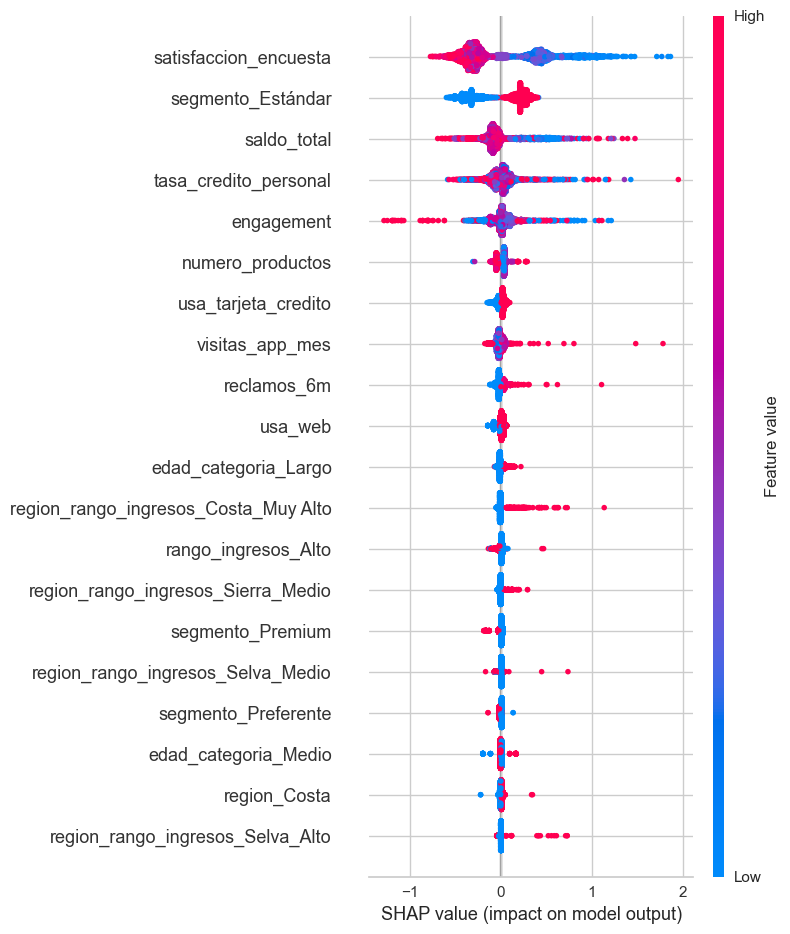

In [35]:
# Detectar si shap_values es una lista (por clase) o una matriz única
if isinstance(shap_values, list):
    # Modelo binario: usar la matriz de la clase positiva
    shap_matrix = shap_values[1]
else:
    # Modelo binario con una sola matriz
    shap_matrix = shap_values

# Ajustar si hay columna extra (offset)
if shap_matrix.shape[1] == X_train_transformed.shape[1] + 1:
    shap_values_fixed = shap_matrix[:, :-1]
else:
    shap_values_fixed = shap_matrix

# Alinear filas si hay desajuste
min_rows = min(shap_values_fixed.shape[0], X_train_transformed.shape[0])
shap.summary_plot(shap_values_fixed[:min_rows], X_train_transformed.iloc[:min_rows])

1) ¿Cuál es el porcentaje de clientes que cerraron su cuenta? ¿Está balanceado el dataset?

In [36]:
# pandas
prop = df['cerrara_cuenta'].mean()   # si 1 = cerró
n_total = len(df)
n_pos = df['cerrara_cuenta'].sum()
print(f"Total: {n_total}, Cerraron: {n_pos} ({prop*100:.2f}%)")

Total: 5000, Cerraron: 702 (14.04%)


Interpretación / regla práctica

Si prop < 5–10% → dataset muy desbalanceado.
Si está entre 10–30% → moderadamente desbalanceado.
Si ~50% → balanceado (poco probable en churn real).

2) ¿Qué variables tienen mayor correlación con cerrara_cuenta?

- Correlación punto-biserial para variables numéricas vs etiqueta binaria.
- Importancia de modelos: feature importance del mejor modelo (Tree gain/permute), y SHAP para interpretación a nivel global y local.
- Información mutua (mutual_info_classif) para no linealidad.

3) ¿Cuál es el mejor modelo en AUC? ¿Y en Recall?

Protocolo de evaluación (recomendado):

Separar dataset: train (60-70%), val (15-20%), test holdout (15-20%) con estratificación por cerrara_cuenta.

Entrenar varios modelos: Logistic Regression (baseline), RandomForest, XGBoost/LightGBM, CatBoost, NeuralNet pequeño.

4) ¿Qué combinación de variables permite identificar clientes silenciosos que se van (sin reclamos)?

Estrategia para encontrar el patrón

1. Crear variables temporales: delta_transacciones_3m, delta_saldo_3m, delta_logins_3m.
2. Variables de interacción: num_reclamos_6m, n_contactos_callcenter_6m, respuesta_campañas_3m.
3. Regla operativa inicial (para análisis / clustering):

    silencioso = (
    delta_transacciones_3m < -X  AND
    delta_saldo_3m < -Y AND
    num_reclamos_6m == 0 AND
    num_logins_3m < threshold
    )

4. Alternativa: hacer clustering sobre comportamiento temporal (k-means / HDBSCAN) para descubrir 
    segmento con baja interacción y luego cruzar con cerrara_cuenta.

5) ¿Qué pasa si el modelo predice mal? (falso positivo vs falso negativo)

    Falso Positivo (FP): modelo predice que cerrara_cuenta=1 pero cliente NO se iba. Acción típica: contactar / ofrecer incentivo.
    
        - Costo de intervención (gestor y oferta económica).
        - Molestia al cliente (riesgo reputacional si se contacta demasiado).
        - Pero suele tener beneficio potencial si oferta apropiada (venta cruzada).

    Falso Negativo (FN): modelo predice no se va pero cliente SÍ cierra.

        - Pérdida de ingreso actual y futuro (alto para cliente premium).
        - Costo de oportunidad enorme en ventas cruzadas futuras.
        - Dificultad para recuperar cliente (switching cost).

Regla general: si pérdida esperada por FN >> costo de FP, optimizar para reducir FN (aumentar Recall), aun a costa de más FP.

6) ¿Qué umbral de score usar (0.5 vs optimizado por KS) para reducir pérdida financiera?

Opciones:

0.5: estándar, no considera desbalance ni coste diferente.

Umbral KS / Youden / ROC:

KS: máximo de (TPR − FPR) (bueno para separar).

Youden J: maximiza sensitivity + specificity - 1.

Cost-based: el mejor, optimiza directamente la pérdida financiera esperada.

7) ¿Cómo explicarías con SHAP que un cliente Premium con buen saldo igual fue predicho como fuga?

El modelo estima que este cliente está en riesgo 82%. Aunque su saldo sigue siendo alto, 3 factores contribuyen fuertemente al riesgo: (1) delta_logins_3m muy negativo —el cliente redujo el uso digital—, (2) prop_transfers_to_other_banks aumentó en 4X —ha empezado a mover fondos fuera—, y (3) respuesta_campañas es 0 —no responde a nuestras ofertas. SHAP muestra que estos tres factores aumentan la probabilidad de cierre en conjunto en +0.45 (log-odds). Si ofrecemos una oferta de retención orientada a actividad digital (p. ej. beneficios en transferencias y asesoría personalizada) podemos reducir ese score

8) ¿Debería el modelo incluir la tasa de interés ofrecida como predictor, si luego esta puede cambiar según la política de retención?

Riesgo (data leakage / feedback loop): si la tasa es una variable que la banca puede cambiar como parte de la intervención, incluirla puede crear un feedback loop donde el modelo aprende patrones que luego el banco altera (variable manipulable)

Recomendación práctica:

Sí, incluirla en entrenamiento histórico si reflejar la realidad histórica ayuda a predecir (por ejemplo, clientes que recibieron mala tasa y luego se fueron). Pero:

    Marcarla como "acciónable": en producción, al decidir intervención no permitir que el modelo use la tasa futura que se aplicará como feature para justificar su propia recomendación.

    Separar dos cosas:
    Modelo predictor: puede incluir tasa histórica para maximizar performance.
    Módulo de decisión (política): cuando simulas ofrecer una nueva tasa, ejecutar un análisis contrafactual para ver efecto (no re-entrenar en tiempo real).


9) ¿Cómo usarías este modelo en un sistema de reglas mixtas (modelo + reglas de negocio) para que los gestores humanos no pierdan confianza?

1. Scoring diario: modelo calcula score_churn y un ranking por riesgo (top N).

2. Reglas de negocio (pre-filtrado):

    - Excluir clientes en campañas activas o con restricciones regulatorias.
    - Priorizar clientes con valor_premium > X (ROI positivo).
    - Limitar # contactos por gestor / día.

3. Política híbrida (ejemplo):

    - Si score > umbral_alto AND valor_premium alto → acción inmediata (gestor senior + oferta personalizada).
    - Si umbral_medio < score ≤ umbral_alto → acción automatizada (email in-app + push).
    - Si score ≤ umbral_medio → monitor (no acción).